# CMIP6 Future Predictions

## General python imports

In [52]:
# general python
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import geopandas as gpd
import pandas as pd
import seaborn as sns

#niceties
from rich import print

# Needed
from ipywidgets import IntProgress
from IPython.display import display
from scipy.stats import qmc

In [53]:
# general eWaterCycle
import ewatercycle
import ewatercycle.models
import ewatercycle.forcing

## Defining the experiment and file paths

In [67]:
# Defining the data period
start_calibration = '1986-01-01'
end_calibration = '2012-12-31'

start_validation = '2013-01-01'
end_validation = '2014-12-31'

future_data_start = '2026-01-01'
future_data_end = '2099-01-01' 


In [55]:
# defining path for catchment shape file
km_shp = Path.home() / "BEP-Zoe/book/thesis_projects/BSc/2025_Q4_ZoeLucius_CEG" /  "km_ERA5" / "km.shp"

# defining destination path for CMIP data
CMIP_folder = Path.home() / "CMIP"
CMIP_folder.mkdir(exist_ok=True)

# model HBV destination path
HBV_model_path = Path.home() / "HBV_model" / "CMIP"
HBV_model_path.mkdir(exist_ok=True)

## Importing the observed data

In [56]:
# The HBV model returns values in mm/day so in order to compare this to the observed data it must b converted to m^3/s
catchment_area_km2 = 334882.8

def mmday_to_m3s(Q_sim_mmday, area_km2):
    return (Q_sim_mmday * area_km2) / 86.4

In [57]:
# Loading in discharge data from Katima Mulilo
katima = (pd.read_csv('Katima_Mulilo/1291100_Q_Day.txt', skiprows=35, delimiter=';', header=1)
          .drop(columns=['hh:mm'])
          .rename(columns={"YYYY-MM-DD": "Date", " Value": "Discharge [m^3/s]"}))

# Creating a dataframe with accessible dates and no invalid data 
katima['Date'] = pd.to_datetime(katima['Date'])
katima['Discharge [m^3/s]'] = katima['Discharge [m^3/s]'].replace(-999.000, np.nan)

# Reducing the dataframe to the calibration period
km = katima[(katima['Date'] >= start_calibration) & (katima['Date'] <= end_validation)]

# Creating a dataframe of the flow data 
flow = pd.DataFrame(data=km['Discharge [m^3/s]'].values, index=km['Date'], columns=['Q'])

## Generating the forcings

In [68]:
CMIP_dataset = {'dataset': 'MPI-ESM1-2-HR', 'project': 'CMIP6', 'grid' : 'gn', 'exp': 'historical', 'ensemble': 'r1i1p1f1'}

CMIP_forcing = ewatercycle.forcing.sources["LumpedMakkinkForcing"].generate(
   dataset=CMIP_dataset,
   start_time=future_data_start+'T00:00:00Z',
   end_time=future_data_end+'T00:00:00Z',
   shape=km_shp,
   directory=CMIP_folder / 'scen_historic',
)

# CMIP_historic = CMIP_folder / "scen_historic" / "work" / "diagnostic" / "script" 
# historic = ewatercycle.forcing.sources["LumpedMakkinkForcing"].load(directory=CMIP_historic)

## Running the HBV model (with CMIP6 data)

In [20]:
# Applying the parameters found in the KGE model fit calibration
params_KGE = [5.65179127, 0.27593564, 779.15056566, 2.45298864, 0.04682875, 1.3263829, 0.01356608, 0.0070803, 0.48990002]

# Define the initial state parameters (Si,  Su, Sf, Ss, Sp)
s_0 = np.array([0,  100,  0,  5,  0])

In [21]:
model = ewatercycle.models.HBV(forcing=historic)

In [22]:
config_file, _ = model.setup(parameters=params_KGE, initial_storage=s_0, cfg_dir = HBV_model_path)

In [23]:
model.initialize(config_file)

In [24]:
Q_m = []
time = []

while model.time < model.end_time:
    model.update()
    Q_m.append(model.get_value("Q")[0])
    time.append(pd.Timestamp(model.time_as_datetime))

In [18]:
model.finalize()

In [26]:
historic_CMIP_output = pd.Series(data=Q_m, name="Modelled_discharge CMIP", index=time)

In [62]:
# The HBV model returns values in mm/day so in order to compare this to the observed data it must b converted to m^3/s
catchment_area_km2 = 334882.8

def mmday_to_m3s(Q_sim_mmday, area_km2):
    return (Q_sim_mmday * area_km2) / 86.4

Q_hist_CMIP = mmday_to_m3s(historic_CMIP_output.values, catchment_area_km2)

df_hist = pd.DataFrame(Q_hist_CMIP)

In [63]:
# get the right period
QCMIP_sim = df_hist[:]
QCMIP_obs = flow[start : end]


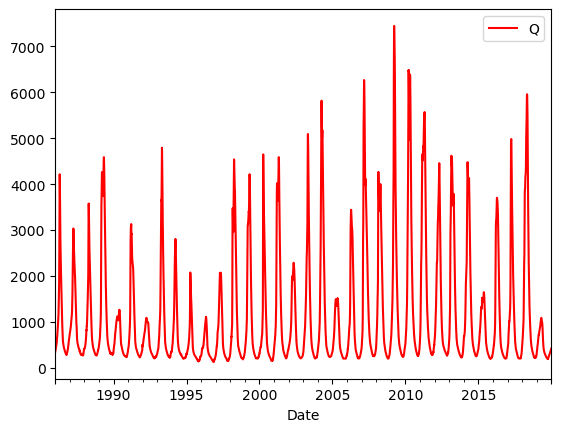

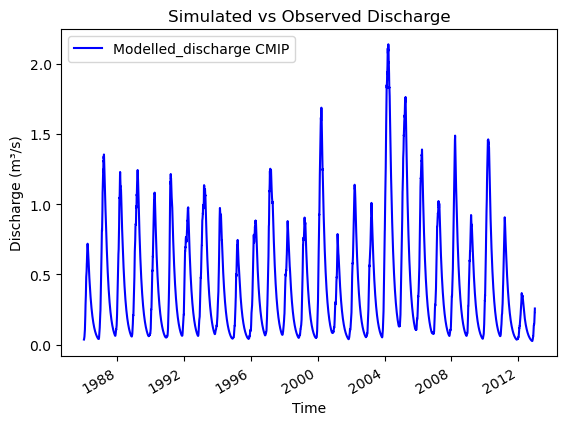

In [64]:
# plot
QCMIP_obs.plot(label="Observed Discharge", color='red')
df.plot(label="Simulated Discharge", color='blue')
plt.title('Simulated vs Observed Discharge')
plt.xlabel('Time')
plt.ylabel('Discharge (m³/s)')
plt.legend()
plt.show()